In [187]:
import lang2vec.lang2vec as l2v
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy import stats
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

from langdist_correl import *

In [188]:
def get_plot(df, plot_path="corr.png", ivec_label="Ivector Euc Distance (LDA)", feature_label="Linguistic Feature Distance", title=None, save=False, ylim=[0,0.8]):
    import seaborn as sns
    sns.set_theme()

    plt.figure()
    x = df['ivector']
    y = df['feature']

    # normalise ivector
    x = (x-x.min())/(x.max()-x.min())



    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)

    plt.plot(x,y , '.', color="black")
    plt.xlabel(ivec_label)
    plt.ylabel(feature_label)
    plt.ylim(ylim)
    
    if title:
        plt.title(title)

    if save:
        plt.savefig(plot_path)

In [189]:
iso_mapping={"ar":"ara", "ca":"cat", "cs":"ces", "cy":"cym", "de":"deu", "rw" :"kin", "en":"eng", "eo":"epo", "es":"spa", "eu":"eus", "fa":"fas", "fr":"fra", "fy-NL":"fry", "it":"ita", "kab":"kab", "nl":"nld", "pl":"pol", "pt":"por", "ru":"rus", "sv-SE":"swe", "ta":"tam", "tr":"tur","tt":"tat", "uk":"ukr", "zh-CN":"zho" }

In [190]:
syntax_vec=read_csv("../../lang_dist/lang_vecs/syntax_knn.csv")
phonology_vec=read_csv("../../lang_dist/lang_vecs/phonology_knn.csv")
inventory_vec=read_csv("../../lang_dist/lang_vecs/inventory_knn.csv")


ivec = iso2_to_iso3(read_csv("lda_ivectors_2048_tr-train_large_all-1h_ts-train_large_all-1h_lang_ivector.csv"))

permutation=False
nperm=999 # default 9999
ivec_label = "Ivector Euc Distance (LDA)"
feature_label = "Linguistic Feature Distance"

#Create a dataframe of features. 
df_feats = pd.DataFrame({"ivector":pd.Series(ivec),"syntax":pd.Series(syntax_vec), "inventory":pd.Series(inventory_vec), "phonology":pd.Series(phonology_vec)})


In [191]:
flatten = lambda t: [item for sublist in t for item in sublist]
df_feats['concat_features'] = df_feats[["syntax", "phonology", "inventory"]].apply(lambda row: flatten([x for x in row.values]), axis=1)
concat_vec = df_feats['concat_features'].to_dict()

In [192]:
ivec2dist = compute_distances(ivec, dist = "cosine")
syntax2dist = compute_distances(syntax_vec)
inventory2dist = compute_distances(inventory_vec)
phonology2dist = compute_distances(phonology_vec)
concat2dist = compute_distances(concat_vec)


syntax_d = reduce_langpair_dic(syntax2dist)
inventory_d = reduce_langpair_dic(inventory2dist)
phonology_d = reduce_langpair_dic(phonology2dist)
ivec_d = reduce_langpair_dic(ivec2dist)
concat_d = reduce_langpair_dic(concat2dist)
#Now create a distance dataframe.
#Euclidean distance for ivectors, otherwise cosine distance. 
df_distances = pd.DataFrame({"ivector":pd.Series(ivec_d),"syntax":pd.Series(syntax_d), "inventory":pd.Series(inventory_d), "phonology":pd.Series(phonology_d), "concat":pd.Series(concat_d)})


In [193]:
df_distances

,ivector,syntax,inventory,phonology,concat
ara-cat,1.077731,0.249066,0.296321,0.183503,0.263212
ara-ces,1.191608,0.363604,0.328558,0.183503,0.325836
ara-cym,0.922322,0.226979,0.284171,0.221501,0.253520
ara-deu,1.209810,0.374570,0.339890,0.171921,0.333160
ara-eng,1.155981,0.349013,0.291936,0.299351,0.320334
...,...,...,...,...,...
tat-ukr,0.900814,0.366632,0.257844,0.087129,0.285542
tat-zho,1.228625,0.402547,0.335922,0.151332,0.338377
tur-ukr,0.836075,0.391966,0.299123,0.046537,0.311069
tur-zho,1.020772,0.428523,0.412055,0.194177,0.391951


# Any correlations ? 

## Syntax vs I-Vectors

100%|██████████| 999/999 [01:14<00:00, 13.47it/s]
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Pearson Correlation score :  0.26370297892087236
There is a significant correlation of r = 0.264 with 95% confidence interval compared to permuted distribution


/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Syntax_knn Cosine Distance')

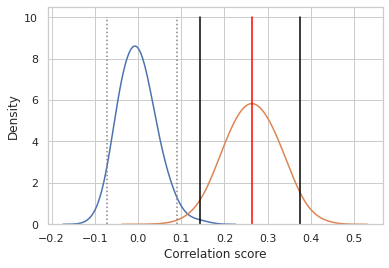

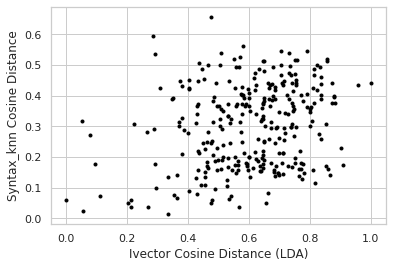

In [194]:
nperm=999

#r here is the median of the bootstrap
r, r_res_altonly, r_boot_altonly = correl_with_perm_and_bootstrap(syntax_vec, ivec, nperm=nperm, ivec_dist="cosine")
print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot_altonly,2.5)
boot_conf_max = np.percentile(r_boot_altonly,97.5)
perm_conf_min = np.percentile(r_res_altonly,2.5)
perm_conf_max = np.percentile(r_res_altonly,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res_altonly
data_boot = r_boot_altonly

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "Ivector Cosine Distance (LDA)"
feature_label="Syntax_knn Cosine Distance"

plt.figure()
x = df_distances['ivector']
y = df_distances['syntax']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())


plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




## Phonology vs I-Vectors

100%|██████████| 999/999 [01:13<00:00, 13.64it/s]

Pearson Correlation score :  0.10018395239002756
There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r=0.1).



/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Phonology_knn Cosine Distance')

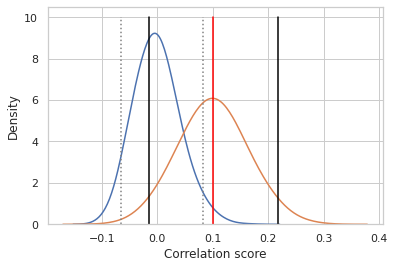

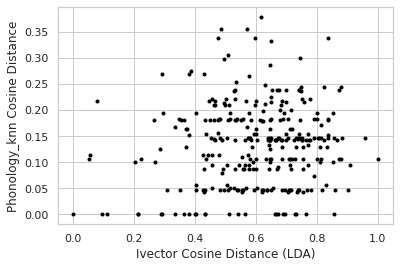

In [195]:
nperm=999

#r here is the median of the bootstrap
r, r_res_altonly, r_boot_altonly = correl_with_perm_and_bootstrap(phonology_vec, ivec, nperm=nperm, ivec_dist="cosine")
print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot_altonly,2.5)
boot_conf_max = np.percentile(r_boot_altonly,97.5)
perm_conf_min = np.percentile(r_res_altonly,2.5)
perm_conf_max = np.percentile(r_res_altonly,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res_altonly
data_boot = r_boot_altonly

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "Ivector Cosine Distance (LDA)"
feature_label="Phonology_knn Cosine Distance"

plt.figure()
x = df_distances['ivector']
y = df_distances['phonology']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())

plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




## Inventory vs I-Vectors

100%|██████████| 999/999 [01:22<00:00, 12.07it/s]

Pearson Correlation score :  0.17697279437682456
There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r=0.177).



/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Inventory_knn Cosine Distance')

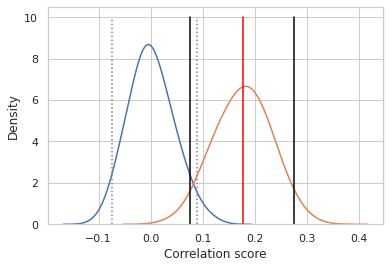

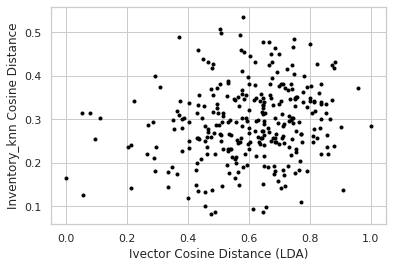

In [196]:
nperm=999

#r here is the median of the bootstrap
r, r_res_altonly, r_boot_altonly = correl_with_perm_and_bootstrap(inventory_vec, ivec, nperm=nperm, ivec_dist="cosine")
print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot_altonly,2.5)
boot_conf_max = np.percentile(r_boot_altonly,97.5)
perm_conf_min = np.percentile(r_res_altonly,2.5)
perm_conf_max = np.percentile(r_res_altonly,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res_altonly
data_boot = r_boot_altonly

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "Ivector Cosine Distance (LDA)"
feature_label="Inventory_knn Cosine Distance"

plt.figure()
x = df_distances['ivector']
y = df_distances['inventory']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())


plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




## Concatenated Distances x Ivectors

100%|██████████| 999/999 [01:37<00:00, 10.27it/s]

Pearson Correlation score :  0.2713721177972415
There is a significant correlation of r = 0.271 with 95% confidence interval compared to permuted distribution



/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Concat_knn Cosine Distance')

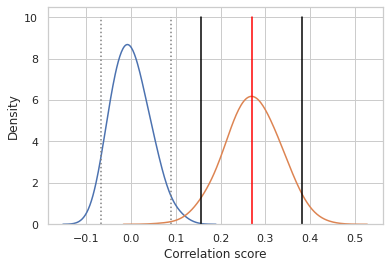

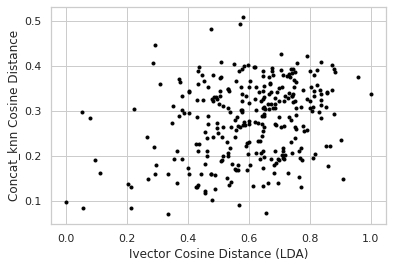

In [197]:
nperm=999

#r here is the median of the bootstrap
r, r_res_altonly, r_boot_altonly = correl_with_perm_and_bootstrap(concat_vec, ivec, nperm=nperm, ivec_dist="cosine")
print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot_altonly,2.5)
boot_conf_max = np.percentile(r_boot_altonly,97.5)
perm_conf_min = np.percentile(r_res_altonly,2.5)
perm_conf_max = np.percentile(r_res_altonly,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res_altonly
data_boot = r_boot_altonly

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "Ivector Cosine Distance (LDA)"
feature_label="Concat_knn Cosine Distance"

plt.figure()
x = df_distances['ivector']
y = df_distances['concat']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())

plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




# Feature Analysis

## 1. Linear Regression

In [198]:
#Prepare data

syntax_df = pd.DataFrame.from_dict(syntax_vec, orient='index', columns=l2v.get_features("eng", "syntax_knn", header=True)["CODE"])
inventory_df = pd.DataFrame.from_dict(inventory_vec, orient='index', columns=l2v.get_features("eng", "inventory_knn", header=True)["CODE"])
phonology_df = pd.DataFrame.from_dict(phonology_vec, orient='index', columns=l2v.get_features("eng", "phonology_knn", header=True)["CODE"])
concat_df = pd.DataFrame.from_dict(concat_vec, orient='index', columns=flatten([l2v.get_features("eng", "syntax_knn", header=True)["CODE"], l2v.get_features("eng", "phonology_knn", header=True)["CODE"], l2v.get_features("eng", "inventory_knn", header=True)["CODE"]]))


syntaxdist_df = pd.DataFrame.from_dict(compute_distances(syntax_vec), orient='index')
phonologydist_df = pd.DataFrame.from_dict(compute_distances(phonology_vec), orient='index')
inventorydist_df = pd.DataFrame.from_dict(compute_distances(inventory_vec), orient='index')
concatdist_df = pd.DataFrame.from_dict(compute_distances(concat_vec), orient='index')

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


### Regression on syntax features

In [200]:
# linear LogisticRegression
reg_syntax = LinearRegression().fit(syntax_df, syntaxdist_df)
reg_syntax.score(syntax_df, syntaxdist_df)
syntax_coefs = pd.DataFrame(reg_syntax.coef_, columns=syntax_df.columns)

syntax_coef_summary = pd.concat([syntax_coefs.mean(),syntax_coefs.std(), syntax_df.mean(), syntax_df.std()], axis=1)
syntax_coef_summary.columns = ["coef_mean", "coef_std", "feat_mean", "feat_std"]

#below sorted absolute value
syntax_coefs_sorted_abs = syntax_coef_summary.reindex(syntax_coef_summary.coef_mean.abs().sort_values(ascending=False).index)


Which are the elements with highest coefficients ?

<AxesSubplot:>

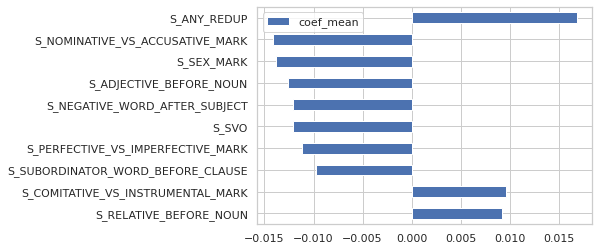

In [201]:
syntax_coefs_sorted_abs[0:10][::-1].plot.barh(y="coef_mean")

### Regression on phonology features

In [202]:
# linear LogisticRegression
reg_phono = LinearRegression().fit(phonology_df, phonologydist_df)
reg_phono.score(phonology_df, phonologydist_df)
phono_coefs = pd.DataFrame(reg_phono.coef_, columns=phonology_df.columns)

phono_coef_summary = pd.concat([phono_coefs.mean(),phono_coefs.std(), phonology_df.mean(), phonology_df.std()], axis=1)
phono_coef_summary.columns = ["coef_mean", "coef_std", "feat_mean", "feat_std"]

#below sorted absolute value
phono_coefs_sorted_abs = phono_coef_summary.reindex(phono_coef_summary.coef_mean.abs().sort_values(ascending=False).index)


<AxesSubplot:>

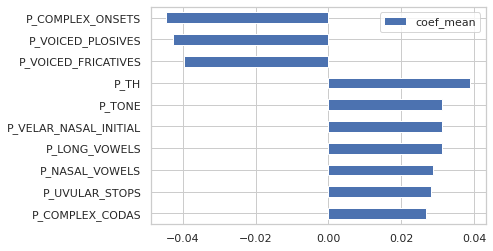

In [203]:
phono_coefs_sorted_abs[0:10][::-1].plot.barh(y="coef_mean")

### Regression on inventory features

In [204]:
# linear LogisticRegression
reg_inv = LinearRegression().fit(inventory_df, inventorydist_df)
reg_inv.score(inventory_df, inventorydist_df)
inv_coefs = pd.DataFrame(reg_inv.coef_, columns=inventory_df.columns)

inv_coef_summary = pd.concat([inv_coefs.mean(),inv_coefs.std(), inventory_df.mean(), inventory_df.std()], axis=1)
inv_coef_summary.columns = ["coef_mean", "coef_std", "feat_mean", "feat_std"]

#below sorted absolute value
inv_coefs_sorted_abs = inv_coef_summary.reindex(inv_coef_summary.coef_mean.abs().sort_values(ascending=False).index)


<AxesSubplot:>

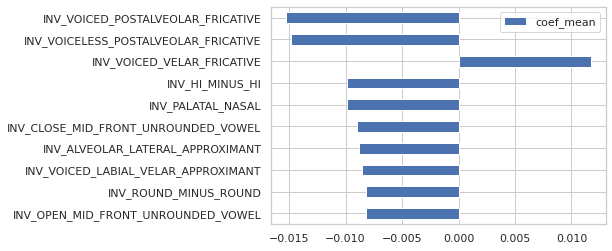

In [205]:
inv_coefs_sorted_abs[0:10][::-1].plot.barh(y="coef_mean")

### Regression on concatenated features

In [206]:
# linear LogisticRegression
reg_concat = LinearRegression().fit(concat_df, concatdist_df)
reg_concat.score(concat_df, concatdist_df)
concat_coefs = pd.DataFrame(reg_concat.coef_, columns=concat_df.columns)

concat_coef_summary = pd.concat([concat_coefs.mean(),concat_coefs.std(), concat_df.mean(), concat_df.std()], axis=1)
concat_coef_summary.columns = ["coef_mean", "coef_std", "feat_mean", "feat_std"]

#below sorted absolute value
concat_coefs_sorted_abs = concat_coef_summary.reindex(concat_coef_summary.coef_mean.abs().sort_values(ascending=False).index)


<AxesSubplot:>

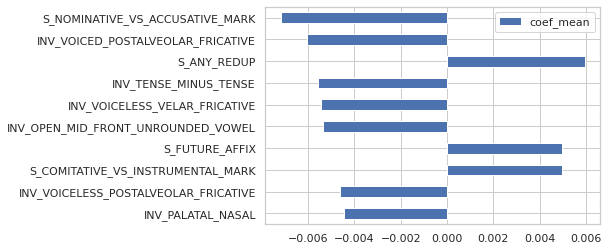

In [207]:
concat_coefs_sorted_abs[0:10][::-1].plot.barh(y="coef_mean")

## 2. RFE (Recursive Feature Elimination)

In [208]:
from sklearn.feature_selection import RFE

def run_rfe(reg, feat_df, featdist_df,coefs, n_features_to_select=10):
    
    rfe = RFE(reg,  n_features_to_select=n_features_to_select, step=1)
    rfe.fit(feat_df, featdist_df) #if no specify, takes one.

    rfe_rank  = pd.DataFrame(rfe.ranking_, index=feat_df.columns, columns=["feat_rank"])
    rfe_rank = pd.concat([rfe_rank, coefs.mean(),coefs.std(), feat_df.mean(), feat_df.std()], axis=1)
    rfe_rank.columns = ["feat_rank","coef_mean", "coef_std", "feat_mean", "feat_std"]

    X_RFE = feat_df[feat_df.columns[rfe.support_]]
    reg_RFE = LinearRegression().fit(X_RFE, featdist_df)
    reg_rfe_score = reg_RFE.score(X_RFE, featdist_df)
    #print("Using only {} features as selected with LFE, we can match a linear regression score of {}".format(n_features_to_select, reg_rfe_score))

    return X_RFE, rfe_rank, reg_rfe_score

Find best features in Syntax

In [209]:
X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_syntax, syntax_df, syntaxdist_df, syntax_coefs, n_features_to_select=1)
rfe_rank.reindex(rfe_rank.feat_rank.sort_values(ascending=True).index)[0:10]

,feat_rank,coef_mean,coef_std,feat_mean,feat_std
S_ANY_REDUP,1,0.016835,0.012364,0.36,0.489898
S_POSSESSOR_AFTER_NOUN,2,-0.009189,0.009718,0.84,0.374166
S_TEND_SUFFIX,3,-0.007745,0.005588,0.96,0.200000
S_NEGATIVE_WORD,4,-0.007099,0.010692,0.76,0.435890
S_DEGREE_WORD_BEFORE_ADJECTIVE,5,-0.008982,0.007370,0.92,0.276887
S_SUBJECT_BEFORE_VERB,6,-0.006216,0.006991,0.92,0.276887
S_NEGATIVE_WORD_BEFORE_OBJECT,7,-0.006644,0.010978,0.68,0.476095
S_OBLIQUE_BEFORE_VERB,8,0.009119,0.007360,0.08,0.276887
S_SVO,9,-0.012070,0.010999,0.72,0.458258
S_NUMCLASS_MARK,10,0.007807,0.009789,0.16,0.374166


Get the evolution of correlation scores when starting with only the n best features. 

Corr with 5 best features : 0.206 (linear regression score : 0.79)
Corr with 25 best features : 0.25 (linear regression score : 0.99)
Corr with 45 best features : 0.269 (linear regression score : 1.0)
Corr with 65 best features : 0.268 (linear regression score : 1.0)
Corr with 85 best features : 0.266 (linear regression score : 1.0)


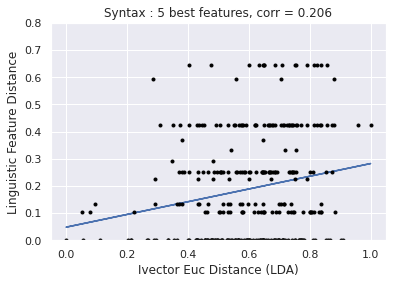

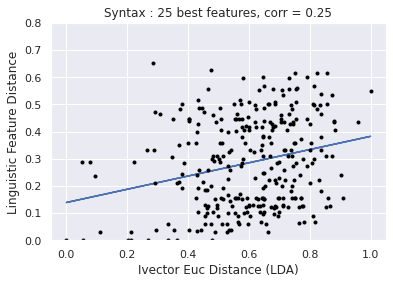

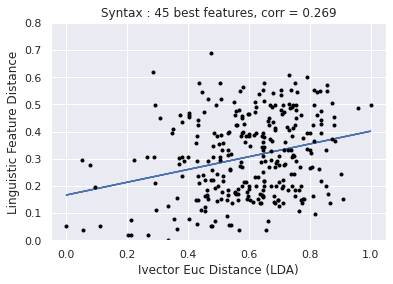

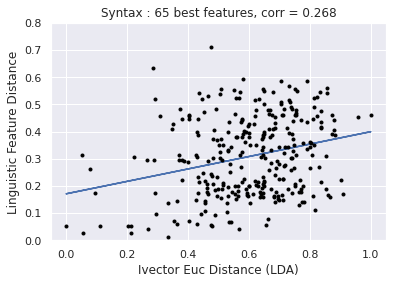

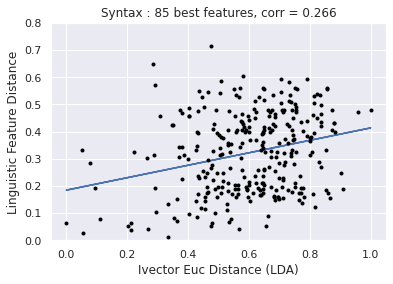

In [210]:

for i in range(5,len(syntax_df.columns),20):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_syntax, syntax_df, syntaxdist_df, syntax_coefs, n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])
    print("Corr with {} best features : {} (linear regression score : {})".format(i, round(corr,3), round(reg_rfe_score,2)))
    
    get_plot(df_RFE, title="Syntax : {} best features, corr = {}".format(i, round(corr,3)), ylim=[0,0.8])

    

  0%|          | 0/102 [00:00<?, ?it/s]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
  1%|          | 1/102 [00:00<00:31,  3.21it/s]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|██████████| 102/102 [00:28<00:00,  3.64it/s]


Text(0, 0.5, 'Correlation Score (syntax vs ivector)')

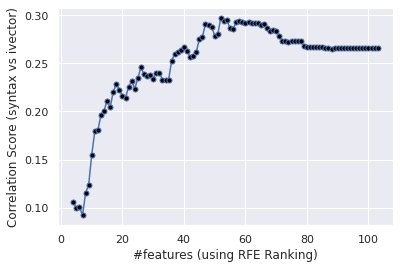

In [211]:
n_feat=[]
corr=[]
pvalue=[]

rfe_iterdict = {}
for i in tqdm(range(2, len(syntax_df.columns)+1)):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_syntax, syntax_df, syntax_coefs,syntaxdist_df,n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])

    
    rfe_iterdict[i] = corr
    
rfe_iter_df = pd.DataFrame.from_dict(rfe_iterdict, orient="index", columns=["corr"])
plt.figure()
plt.plot(rfe_iter_df.index, rfe_iter_df['corr'], marker='o', markersize=5, mfc='black')
plt.xlabel("#features (using RFE Ranking)")
plt.ylabel("Correlation Score (syntax vs ivector)")
    

Find best features in Phonology

In [212]:
X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_phono, phonology_df, phonologydist_df, phono_coefs, n_features_to_select=1)
rfe_rank.reindex(rfe_rank.feat_rank.sort_values(ascending=True).index)[0:10]

,feat_rank,coef_mean,coef_std,feat_mean,feat_std
P_LONG_VOWELS,1,0.031252,0.015057,0.04,0.200000
P_UVULARS,2,0.022505,0.038221,0.24,0.435890
P_VELAR_NASAL_INITIAL,3,0.031252,0.015057,0.04,0.200000
P_TH,4,0.039029,0.026857,0.08,0.276887
P_VOICED_FRICATIVES,5,-0.039677,0.031878,0.92,0.276887
P_COMPLEX_ONSETS,6,-0.044677,0.023299,0.96,0.200000
P_PHARYNGEALS,7,0.026727,0.012724,0.04,0.200000
P_TONE,8,0.031252,0.015057,0.04,0.200000
P_FRONT_ROUND_VOWELS,9,0.011218,0.043544,0.36,0.489898
P_CODAS,10,-0.022606,0.044469,0.68,0.476095


/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Corr with 5 best features : nan (linear regression score : 0.7)
Corr with 25 best features : 0.101 (linear regression score : 1.0)


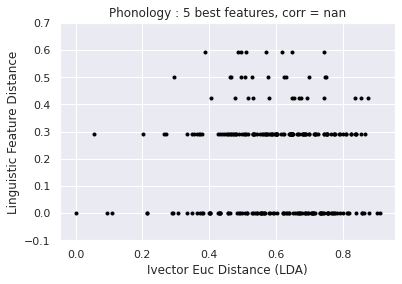

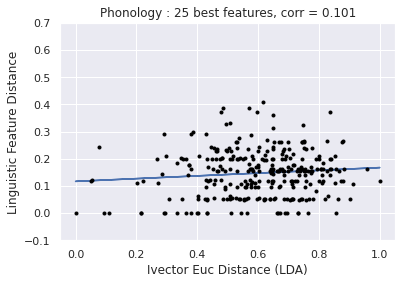

In [213]:

for i in range(5,len(phonology_df.columns),20):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_phono, phonology_df, phonologydist_df, phono_coefs, n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])
    print("Corr with {} best features : {} (linear regression score : {})".format(i, round(corr,3), round(reg_rfe_score,2)))
    
    get_plot(df_RFE, title="Phonology : {} best features, corr = {}".format(i, round(corr,3)), ylim=[-0.1,0.7])

    

  0%|          | 0/27 [00:00<?, ?it/s]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Text(0, 0.5, 'Correlation Score (phonology vs ivector)')

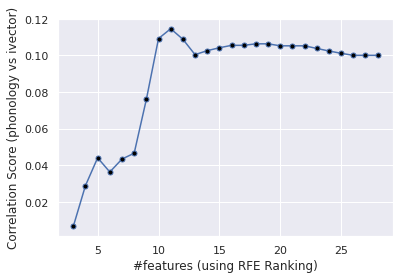

In [214]:
n_feat=[]
corr=[]
pvalue=[]

rfe_iterdict = {}
for i in tqdm(range(2, len(phonology_df.columns)+1)):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_phono, phonology_df, phono_coefs, phonologydist_df,n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])

    
    rfe_iterdict[i] = corr
    
rfe_iter_df = pd.DataFrame.from_dict(rfe_iterdict, orient="index", columns=["corr"])
plt.figure()
plt.plot(rfe_iter_df.index, rfe_iter_df['corr'], marker='o', markersize=5, mfc='black')
plt.xlabel("#features (using RFE Ranking)")
plt.ylabel("Correlation Score (phonology vs ivector)")
    

Find best features in Inventory

In [215]:
X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_inv, inventory_df, inventorydist_df, inv_coefs, n_features_to_select=1)
rfe_rank.reindex(rfe_rank.feat_rank.sort_values(ascending=True).index)[0:10]

,feat_rank,coef_mean,coef_std,feat_mean,feat_std
INV_PLACE_LABIOVELAR,1,-0.007735,0.007366,0.92,0.276887
INV_VOICED_ALVEOLAR_PLOSIVE,2,-0.005331,0.009136,0.84,0.374166
INV_SON_VD_VLESS,3,0.005690,0.005058,0.08,0.276887
INV_ROUND_MINUS_ROUND,4,-0.008238,0.011397,0.52,0.509902
INV_PALATAL_APPROXIMANT,5,-0.006564,0.008576,0.88,0.331662
INV_ALVEOLAR_LATERAL_APPROXIMANT,6,-0.008839,0.007380,0.92,0.276887
INV_VOICED_UVULAR_FRICATIVE,7,0.000235,0.010049,0.20,0.408248
INV_VOICELESS_PALATAL_PLOSIVE,8,0.004322,0.010563,0.20,0.408248
INV_PALATAL_NASAL,9,-0.009859,0.011920,0.56,0.506623
INV_VOICED_LABIAL_VELAR_APPROXIMANT,10,-0.008590,0.011049,0.68,0.476095


Corr with 5 best features : 0.103 (linear regression score : 0.6)
Corr with 25 best features : 0.087 (linear regression score : 1.0)
Corr with 45 best features : 0.153 (linear regression score : 1.0)
Corr with 65 best features : 0.154 (linear regression score : 1.0)
Corr with 85 best features : 0.159 (linear regression score : 1.0)
Corr with 105 best features : 0.164 (linear regression score : 1.0)
Corr with 125 best features : 0.173 (linear regression score : 1.0)
Corr with 145 best features : 0.176 (linear regression score : 1.0)


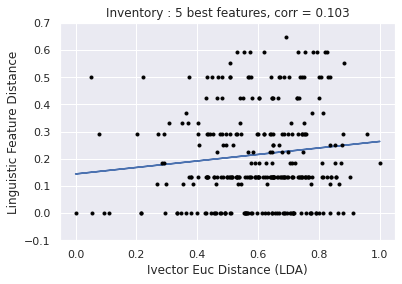

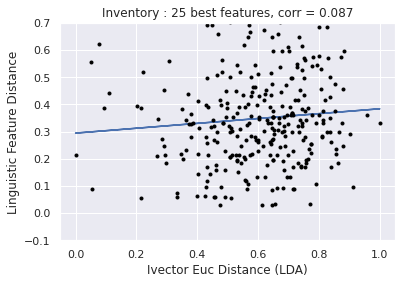

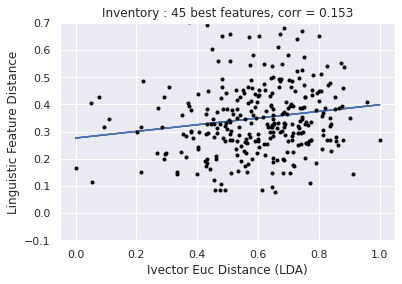

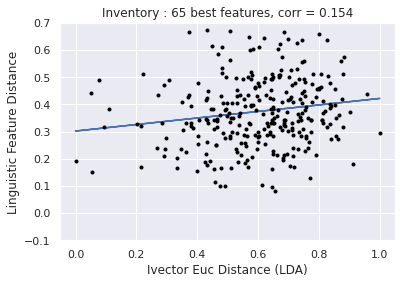

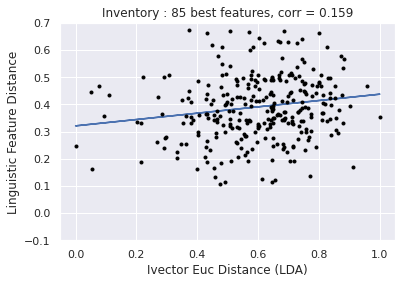

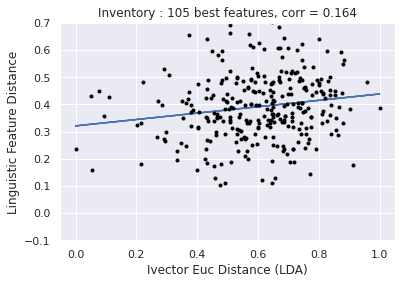

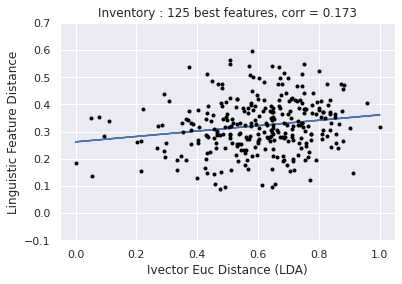

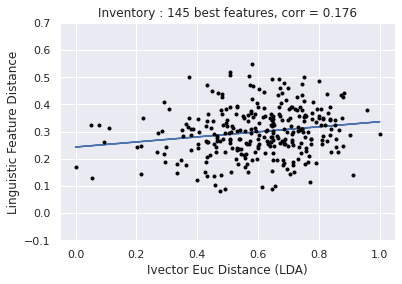

In [216]:
for i in range(5,len(inventory_df.columns),20):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_inv, inventory_df, inventorydist_df, phono_coefs, n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])
    print("Corr with {} best features : {} (linear regression score : {})".format(i, round(corr,3), round(reg_rfe_score,2)))
    
    get_plot(df_RFE, title="Inventory : {} best features, corr = {}".format(i, round(corr,3)), ylim=[-0.1,0.7])

    

  0%|          | 0/157 [00:00<?, ?it/s]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
  1%|          | 1/157 [00:00<01:31,  1.70it/s]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Text(0, 0.5, 'Correlation Score (inventory vs ivector)')

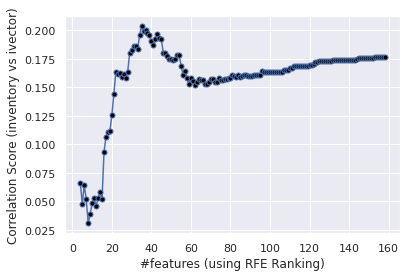

In [217]:
n_feat=[]
corr=[]
pvalue=[]

rfe_iterdict = {}
for i in tqdm(range(2, len(inventory_df.columns)+1)):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_inv, inventory_df, inv_coefs, inventorydist_df,n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])

    
    rfe_iterdict[i] = corr
    
rfe_iter_df = pd.DataFrame.from_dict(rfe_iterdict, orient="index", columns=["corr"])
plt.figure()
plt.plot(rfe_iter_df.index, rfe_iter_df['corr'], marker='o', markersize=5, mfc='black')
plt.xlabel("#features (using RFE Ranking)")
plt.ylabel("Correlation Score (inventory vs ivector)")
    

Find best features in Concatenated

In [218]:
X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_concat, concat_df, concatdist_df, concat_coefs, n_features_to_select=1)
rfe_rank.reindex(rfe_rank.feat_rank.sort_values(ascending=True).index)[0:10]

,feat_rank,coef_mean,coef_std,feat_mean,feat_std
S_ANY_REDUP,1,0.005963,0.005202,0.36,0.489898
S_POSSESSOR_AFTER_NOUN,2,-0.003406,0.003953,0.84,0.374166
S_PAST_VS_PRESENT_MARK,3,-0.003153,0.002921,0.92,0.276887
S_ADJECTIVE_WITHOUT_NOUN,4,-0.002942,0.004698,0.72,0.458258
S_PERFECTIVE_VS_IMPERFECTIVE_MARK,5,-0.003202,0.004779,0.72,0.458258
S_ADJECTIVE_BEFORE_NOUN,6,-0.002445,0.004685,0.76,0.435890
INV_TENSE_MINUS_TENSE,7,-0.005556,0.005172,0.44,0.506623
S_SEX_MARK,8,-0.002669,0.004653,0.76,0.435890
S_NEGATIVE_AFFIX,9,0.001979,0.004928,0.28,0.458258
S_SVO,10,-0.002905,0.004892,0.72,0.458258


Corr with 5 best features : 0.234 (linear regression score : 0.67)
Corr with 25 best features : 0.278 (linear regression score : 0.99)
Corr with 45 best features : 0.288 (linear regression score : 1.0)
Corr with 65 best features : 0.285 (linear regression score : 1.0)
Corr with 85 best features : 0.296 (linear regression score : 1.0)
Corr with 105 best features : 0.291 (linear regression score : 1.0)
Corr with 125 best features : 0.28 (linear regression score : 1.0)
Corr with 145 best features : 0.278 (linear regression score : 1.0)
Corr with 165 best features : 0.271 (linear regression score : 1.0)
Corr with 185 best features : 0.27 (linear regression score : 1.0)
Corr with 205 best features : 0.269 (linear regression score : 1.0)
Corr with 225 best features : 0.27 (linear regression score : 1.0)
Corr with 245 best features : 0.271 (linear regression score : 1.0)
Corr with 265 best features : 0.272 (linear regression score : 1.0)
Corr with 285 best features : 0.272 (linear regression 

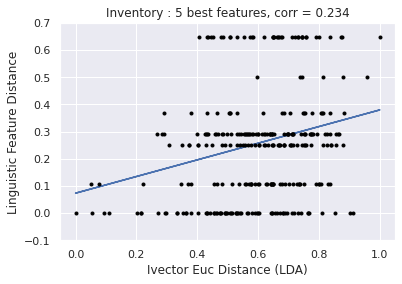

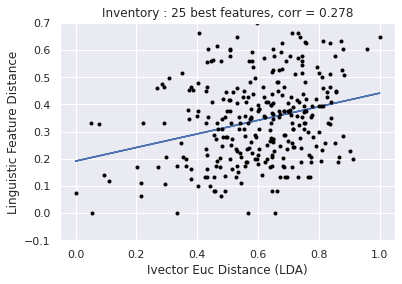

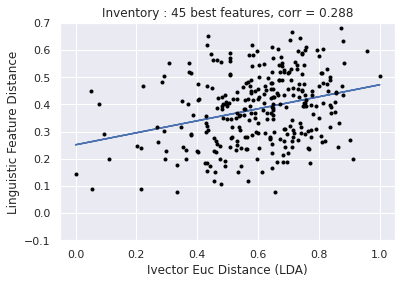

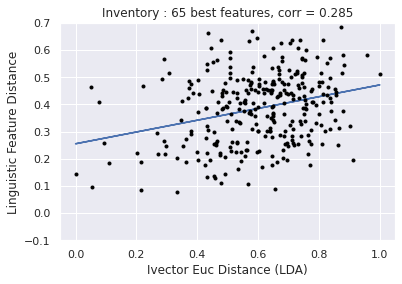

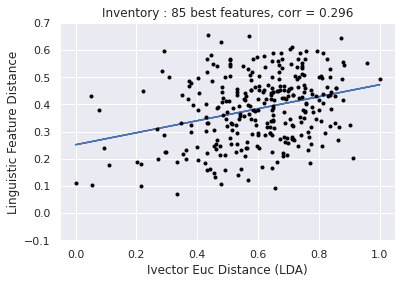

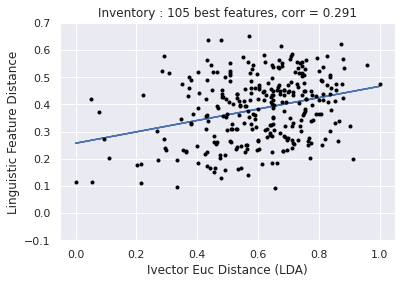

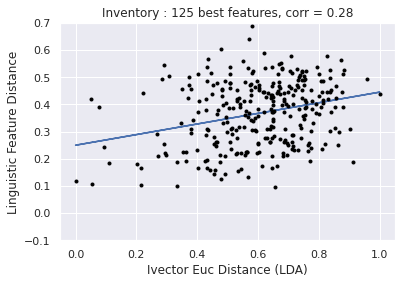

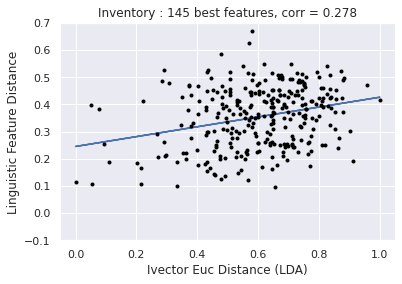

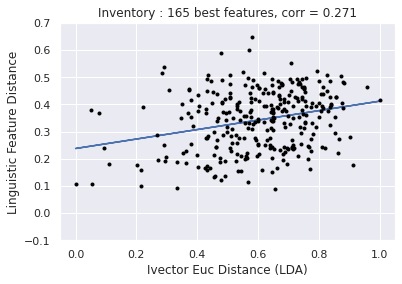

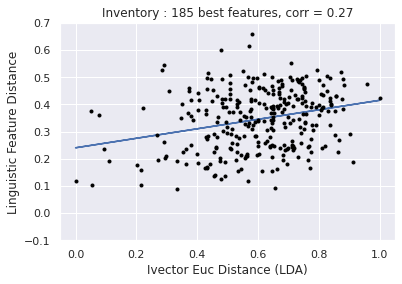

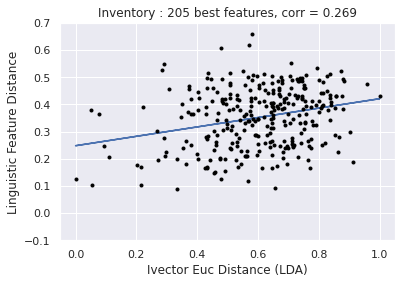

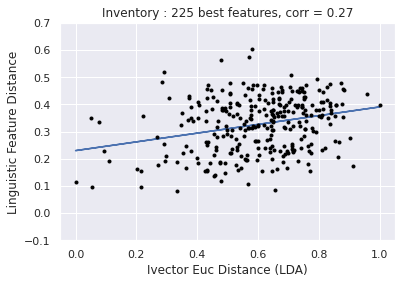

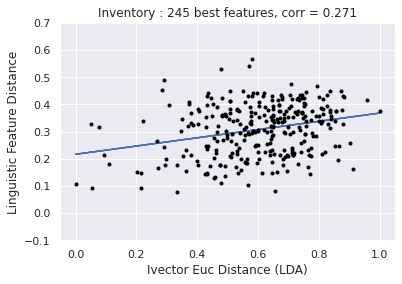

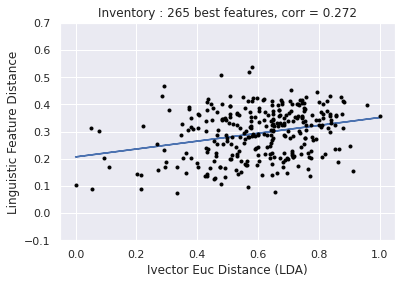

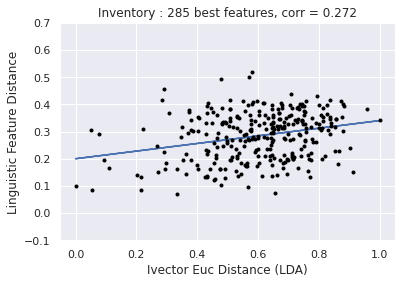

In [219]:
for i in range(5,len(concat_df.columns),20):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_concat, concat_df, concatdist_df, concat_coefs, n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])
    print("Corr with {} best features : {} (linear regression score : {})".format(i, round(corr,3), round(reg_rfe_score,2)))
    
    get_plot(df_RFE, title="Inventory : {} best features, corr = {}".format(i, round(corr,3)), ylim=[-0.1,0.7])

    

  0%|          | 0/288 [00:00<?, ?it/s]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
  0%|          | 1/288 [00:01<08:29,  1.77s/it]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
  1%|          | 2/288 [00:03<08:13,  1.72s/it]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
  1%|          | 3/288 [00:04<07:22,  1.55s/it]/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|██████████| 288/288 [06:34<00:00,  1.37s/it]


Text(0, 0.5, 'Correlation Score (concat vs ivector)')

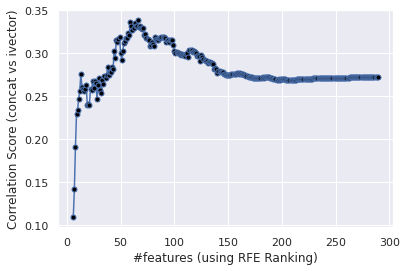

In [220]:
n_feat=[]
corr=[]
pvalue=[]

rfe_iterdict = {}
for i in tqdm(range(2, len(concat_df.columns)+1)):
    X_RFE, rfe_rank, reg_rfe_score = run_rfe(reg_concat, concat_df, concat_coefs, concatdist_df,n_features_to_select=i)
    df_RFE = create_df(X_RFE.T.to_dict('list'), ivec, ivec_dist="cosine")
    
    corr = pearsonr(df_RFE['feature'], df_RFE['ivector'])

    
    rfe_iterdict[i] = corr
    
rfe_iter_df = pd.DataFrame.from_dict(rfe_iterdict, orient="index", columns=["corr"])
plt.figure()
plt.plot(rfe_iter_df.index, rfe_iter_df['corr'], marker='o', markersize=5, mfc='black')
plt.xlabel("#features (using RFE Ranking)")
plt.ylabel("Correlation Score (concat vs ivector)")
    

# Try to use langvecs from Malaviya. 

In [221]:
m_lang_vecs = np.load("../../lang_dist/lang_vecs/lang_vecs.npy", allow_pickle=True,encoding = 'latin1').item()
m_cell_vecs = np.load("../../lang_dist/lang_vecs/lang_cell_states.npy", allow_pickle=True,encoding = 'latin1').item()

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

m_lang_vecs = dict((remove_prefix(key,'optsrc'), value) for (key, value) in m_lang_vecs.items())

#---------------------------------------------------------------

common = [k for k in ivec.keys() if k in m_lang_vecs.keys()]
missing = [k for k in ivec.keys() if k not in common]
print(missing)
#ara to arb
#kab missing
#eng missing ?!
#fas to pes
#fry (frisian) missing

#replace missing languages
m_lang_vecs['ara'] = m_lang_vecs.pop('arb')
m_cell_vecs['ara'] = m_cell_vecs.pop('arb')
m_lang_vecs['fas'] = m_lang_vecs.pop('pes')
m_cell_vecs['fas'] = m_cell_vecs.pop('pes')

#---------------------------------------------------------------


#onyl use keys we have
m_lang_vecs = {k:v for k,v in m_lang_vecs.items() if k in ivec.keys()}
m_cell_vecs = {k:v[0] for k,v in m_cell_vecs.items() if k in ivec.keys()}

ivec_filtered = {k:v for k,v in ivec.items() if k in m_cell_vecs.keys()}
syntax_vec_filtered = {k:v for k,v in syntax_vec.items() if k in m_cell_vecs.keys()}
phonology_vec_filtered = {k:v for k,v in phonology_vec.items() if k in m_cell_vecs.keys()}
inventory_vec_filtered = {k:v for k,v in inventory_vec.items() if k in m_cell_vecs.keys()}




['kab', 'ara', 'eng', 'fas', 'fry']


#### Do the lang vectors from Malaviya correlate with our centroid i-vectors ? 

Pearson Correlation score :  -0.0020438930874748643


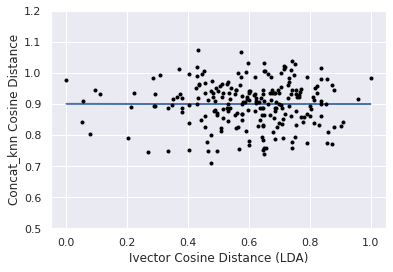

In [222]:
df = create_df(m_lang_vecs, ivec_filtered, ivec_dist="cosine")
corr = pearsonr(df['ivector'], df['feature']) #should find a way to get all missing languages
print("Pearson Correlation score : ", corr)
    

get_plot(df, ivec_label=ivec_label, feature_label=feature_label, ylim=[0.5, 1.2])


It seems not. Now let's try to see if the cell states from Malaviya correlate with our centroid ivectors
*Always keep in mind that because of some missing languages, we are only using 20 languages here*

Pearson Correlation score :  0.13380470166281788


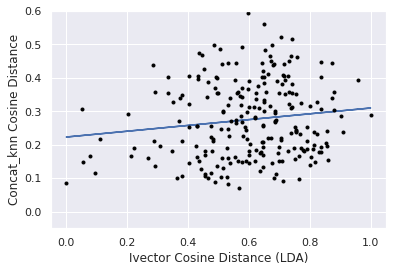

In [223]:
df = create_df(m_cell_vecs, ivec_filtered, ivec_dist="cosine")

permutation=False
nperm=9999
if permutation : 
    corr, p_value, r_res_altonly = correl_with_perm(m_cell_vecs, ivec_filtered, nperm=nperm)
    print("Pearson Correlation score : ", corr, " and p.value of : ", p_value)
    
    sns.set_theme()
    
    #sig plot
    data = r_res_altonly
    plt.figure()
    sns.set_style('whitegrid')
    sns.kdeplot(np.array(data), bw=0.5)
    plt.plot([corr, corr], [0, 2])
    plt.xlabel("Correlation score")


else:
    corr = pearsonr(df['ivector'], df['feature'])
    print("Pearson Correlation score : ", corr)
    

get_plot(df, ivec_label=ivec_label, feature_label=feature_label, ylim=[-0.05,0.6])



Ok, this time it seems like the cell_vecs from Malaviya et al correlate with our centroid ivectors, and this significantly (Pearson Correlation score :  0.359  p = 0.021)

In [224]:

for ling_vec, ling in zip([syntax_vec_filtered, phonology_vec_filtered, inventory_vec_filtered], ["syntax", "phonology", "inventory"]) :
    df = create_df(ling_vec, m_cell_vecs, ivec_dist="cosine")
    corr = pearsonr(df['ivector'], df['feature'])
    print("{} vs Cells : Pearson Correlation score : ".format(ling), corr)




syntax vs Cells : Pearson Correlation score :  0.4293840473857826
phonology vs Cells : Pearson Correlation score :  0.29737056529124556
inventory vs Cells : Pearson Correlation score :  0.18733823140121109


## Now we want to compare it with the LFE scores. 

In [225]:
lfe_dic=read_csv("../../lang_dist/lfe_cv_hd.csv")

In [226]:
m_celldist = compute_distances(m_cell_vecs)
mcell = reduce_langpair_dic(m_celldist)

# = compute_distances(feat_vec)
#feat = reduce_langpair_dic(featdist)
#Get LFE dic from csv. 

lfe_dic = {}
for k,v in read_csv("../../lang_dist/lfe_cv_hd.csv").items():
    l1 = iso_mapping[k.split('-')[0]]
    l2 = iso_mapping[k.split('-')[1]]
    
    lfe_dic['-'.join([l1, l2])] = v[0]
    lfe_dic['-'.join([l2, l1])] = v[0]
    
df_lfe = pd.DataFrame({"syntax":pd.Series(syntax_d), "phonology":pd.Series(phonology_d),"concat":pd.Series(concat_d), "inventory":pd.Series(inventory_d), "lfe":pd.Series(lfe_dic)}).dropna()
#doing another below because less language pairs with m cells
df_lfe_mcells = pd.DataFrame({"m_cells":pd.Series(mcell),"syntax":pd.Series(syntax_d), "concat":pd.Series(concat_d),"phonology":pd.Series(phonology_d), "inventory":pd.Series(inventory_d), "lfe":pd.Series(lfe_dic)}).dropna()

In [227]:
df_lfe

,syntax,phonology,concat,inventory,lfe
cat-cym,0.170732,0.046537,0.168958,0.194891,8.393704
cat-deu,0.166430,0.154846,0.206519,0.253797,12.488551
cat-eng,0.127057,0.141884,0.191259,0.247868,5.796804
cat-fas,0.366444,0.087129,0.271352,0.232351,16.525812
cat-fra,0.156565,0.210648,0.180584,0.192393,23.721819
cat-ita,0.012270,0.000000,0.070358,0.144047,3.107066
cat-kab,0.243902,0.141884,0.329022,0.464870,20.420406
cat-kin,0.435154,0.105573,0.307023,0.232351,24.689024
cym-deu,0.309328,0.113595,0.226611,0.183503,-17.099565
cym-eng,0.281105,0.181818,0.241296,0.221501,-8.809332


## LFExSyntax ?
(The reason we don't get the same scores are precedently is because 
1) different syntax vectors (original distances don't use the KNN)
2) different centroid ivectors (here we use the ones calculated on the 1h segment and with all 25 languages...)

100%|██████████| 99/99 [00:07<00:00, 12.85it/s]

Pearson Correlation score :  0.37986812488552507
There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r=0.38).



/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Concat_knn Cosine Distance')

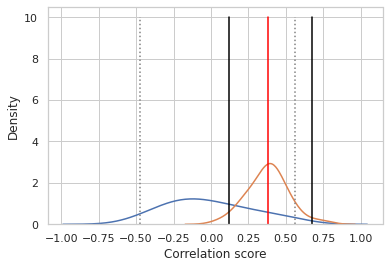

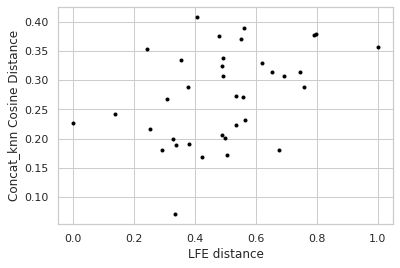

In [228]:
nperm=99


feat = reduce_langpair_dic(compute_distances(syntax_vec))
df = pd.DataFrame({"feat":pd.Series(feat), "lfe":pd.Series(lfe_dic)}).dropna()

r_res = []
r_boot = []

for x in tqdm(range(nperm)):
    #if x%100 == 0:
    #    print("iteration #", x)
    feat_vec_perm=random_dict_shuffle(syntax_vec)
    feat_perm = reduce_langpair_dic(compute_distances(feat_vec_perm))
    
    tmp_df = pd.DataFrame({"feat":pd.Series(feat_perm), "lfe":pd.Series(lfe_dic)}).dropna()
    r_res.append(pearsonr(tmp_df['feat'], tmp_df['lfe']))

    df_bootstrap = df.sample(frac=1, replace=True)
    r_boot.append(pearsonr(df_bootstrap['feat'], df_bootstrap['lfe']))
    
r = np.mean(r_boot)
r_boot = np.sort(r_boot)
r_res = np.sort(r_res)



print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot,2.5)
boot_conf_max = np.percentile(r_boot,97.5)
perm_conf_min = np.percentile(r_res,2.5)
perm_conf_max = np.percentile(r_res,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res
data_boot = r_boot

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "LFE distance"
feature_label="Syntax_knn Cosine Distance"

plt.figure()
x = df_lfe['lfe']
y = df_lfe['concat']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())

plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




## Concat x LFE

100%|██████████| 9999/9999 [13:12<00:00, 12.61it/s]
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Pearson Correlation score :  0.40367419331587345
There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r=0.404).


Text(0, 0.5, 'Concat_knn Cosine Distance')

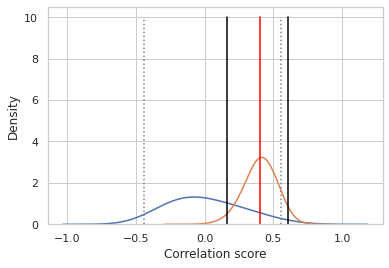

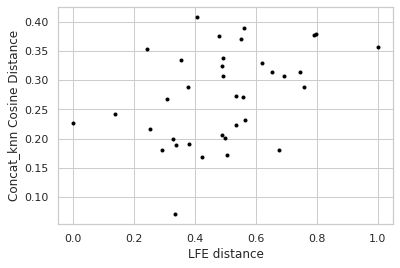

In [229]:
nperm=9999


feat = reduce_langpair_dic(compute_distances(concat_vec))
df = pd.DataFrame({"concat":pd.Series(feat), "lfe":pd.Series(lfe_dic)}).dropna()

r_res = []
r_boot = []

for x in tqdm(range(nperm)):
    #if x%100 == 0:
    #    print("iteration #", x)
    feat_vec_perm=random_dict_shuffle(concat_vec)
    feat_perm = reduce_langpair_dic(compute_distances(feat_vec_perm))
    
    tmp_df = pd.DataFrame({"concat":pd.Series(feat_perm), "lfe":pd.Series(lfe_dic)}).dropna()
    r_res.append(pearsonr(tmp_df['concat'], tmp_df['lfe']))

    df_bootstrap = df.sample(frac=1, replace=True)
    r_boot.append(pearsonr(df_bootstrap['concat'], df_bootstrap['lfe']))
    
r = np.mean(r_boot)
r_boot = np.sort(r_boot)
r_res = np.sort(r_res)



print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot,2.5)
boot_conf_max = np.percentile(r_boot,97.5)
perm_conf_min = np.percentile(r_res,2.5)
perm_conf_max = np.percentile(r_res,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res
data_boot = r_boot

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "LFE distance"
feature_label="Concat_knn Cosine Distance"

plt.figure()
x = df_lfe['lfe']
y = df_lfe['concat']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())

plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




## LFExPhonology ?


100%|██████████| 99/99 [00:04<00:00, 23.98it/s]
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Pearson Correlation score :  0.22025320760843647
There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r=0.22).


Text(0, 0.5, 'Concat_knn Cosine Distance')

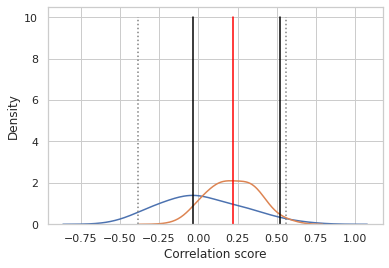

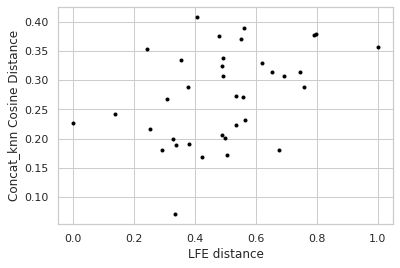

In [230]:
nperm=99


feat = reduce_langpair_dic(compute_distances(phonology_vec))
df = pd.DataFrame({"feat":pd.Series(feat), "lfe":pd.Series(lfe_dic)}).dropna()

r_res = []
r_boot = []

for x in tqdm(range(nperm)):
    #if x%100 == 0:
    #    print("iteration #", x)
    feat_vec_perm=random_dict_shuffle(phonology_vec)
    feat_perm = reduce_langpair_dic(compute_distances(feat_vec_perm))
    
    tmp_df = pd.DataFrame({"feat":pd.Series(feat_perm), "lfe":pd.Series(lfe_dic)}).dropna()
    r_res.append(pearsonr(tmp_df['feat'], tmp_df['lfe']))

    df_bootstrap = df.sample(frac=1, replace=True)
    r_boot.append(pearsonr(df_bootstrap['feat'], df_bootstrap['lfe']))
    
r = np.mean(r_boot)
r_boot = np.sort(r_boot)
r_res = np.sort(r_res)



print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot,2.5)
boot_conf_max = np.percentile(r_boot,97.5)
perm_conf_min = np.percentile(r_res,2.5)
perm_conf_max = np.percentile(r_res,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res
data_boot = r_boot

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "LFE distance"
feature_label="Concat_knn Cosine Distance"

plt.figure()
x = df_lfe['lfe']
y = df_lfe['concat']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())

plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




## LFExInventory ?


100%|██████████| 99/99 [00:05<00:00, 18.63it/s]
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Pearson Correlation score :  0.19797715994046294
There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r=0.198).


/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Concat_knn Cosine Distance')

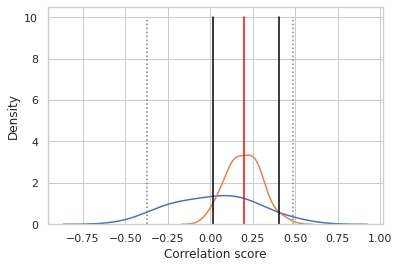

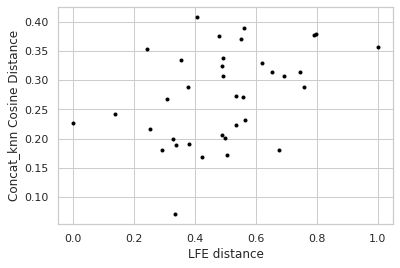

In [231]:
nperm=99


feat = reduce_langpair_dic(compute_distances(inventory_vec))
df = pd.DataFrame({"feat":pd.Series(feat), "lfe":pd.Series(lfe_dic)}).dropna()

r_res = []
r_boot = []

for x in tqdm(range(nperm)):
    #if x%100 == 0:
    #    print("iteration #", x)
    feat_vec_perm=random_dict_shuffle(inventory_vec)
    feat_perm = reduce_langpair_dic(compute_distances(feat_vec_perm))
    
    tmp_df = pd.DataFrame({"feat":pd.Series(feat_perm), "lfe":pd.Series(lfe_dic)}).dropna()
    r_res.append(pearsonr(tmp_df['feat'], tmp_df['lfe']))

    df_bootstrap = df.sample(frac=1, replace=True)
    r_boot.append(pearsonr(df_bootstrap['feat'], df_bootstrap['lfe']))
    
r = np.mean(r_boot)
r_boot = np.sort(r_boot)
r_res = np.sort(r_res)



print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot,2.5)
boot_conf_max = np.percentile(r_boot,97.5)
perm_conf_min = np.percentile(r_res,2.5)
perm_conf_max = np.percentile(r_res,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res
data_boot = r_boot

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "LFE distance"
feature_label="Concat_knn Cosine Distance"

plt.figure()
x = df_lfe['lfe']
y = df_lfe['concat']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())

plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




## LFE x Concat

100%|██████████| 999/999 [01:05<00:00, 15.31it/s]
/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Pearson Correlation score :  0.40777989626492006
There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r=0.408).


/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Concat_knn Cosine Distance')

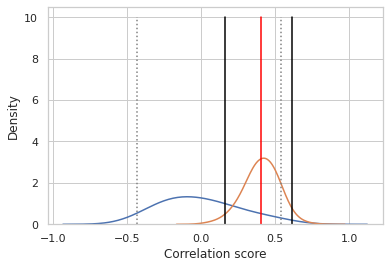

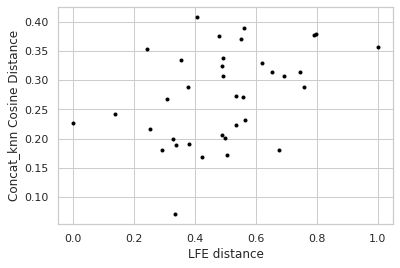

In [232]:
nperm=999


feat = reduce_langpair_dic(compute_distances(concat_vec))
df = pd.DataFrame({"feat":pd.Series(feat), "lfe":pd.Series(lfe_dic)}).dropna()

r_res = []
r_boot = []

for x in tqdm(range(nperm)):
    #if x%100 == 0:
    #    print("iteration #", x)
    feat_vec_perm=random_dict_shuffle(concat_vec)
    feat_perm = reduce_langpair_dic(compute_distances(feat_vec_perm))
    
    tmp_df = pd.DataFrame({"feat":pd.Series(feat_perm), "lfe":pd.Series(lfe_dic)}).dropna()
    r_res.append(pearsonr(tmp_df['feat'], tmp_df['lfe']))

    df_bootstrap = df.sample(frac=1, replace=True)
    r_boot.append(pearsonr(df_bootstrap['feat'], df_bootstrap['lfe']))
    
r = np.mean(r_boot)
r_boot = np.sort(r_boot)
r_res = np.sort(r_res)



print("Pearson Correlation score : ", r)

boot_conf_min = np.percentile(r_boot,2.5)
boot_conf_max = np.percentile(r_boot,97.5)
perm_conf_min = np.percentile(r_res,2.5)
perm_conf_max = np.percentile(r_res,97.5)

if boot_conf_min > perm_conf_max : 
    print("There is a significant correlation of r = {} with 95% confidence interval compared to permuted distribution".format(round(r,3)))
else: 
    print("There is NO significant correlation using a  95% confidence interval with permuted alternative hypothesis (r={}).".format(round(r,3)))


sns.set_theme()

#sig plot
data_perm = r_res
data_boot = r_boot

plt.figure()
sns.set_style('whitegrid')
sns.kdeplot(np.array(data_perm), bw=0.5)
sns.kdeplot(np.array(data_boot), bw=0.5)

plt.xlabel("Correlation score")
plt.plot([r, r], [0, 10], color="red")


plt.plot([boot_conf_min, boot_conf_min], [0, 10], color='black')
plt.plot([boot_conf_max, boot_conf_max], [0, 10], color='black')

plt.plot([perm_conf_min, perm_conf_min], [0, 10], color='grey', linestyle='dotted')
plt.plot([perm_conf_max, perm_conf_max], [0, 10], color='grey', linestyle='dotted')



# Now create the correlation figure. 
ivec_label = "LFE distance"
feature_label="Concat_knn Cosine Distance"

plt.figure()
x = df_lfe['lfe']
y = df_lfe['concat']
# normalise ivector
x = (x-x.min())/(x.max()-x.min())

plt.plot(x,y , '.', color="black")
plt.xlabel(ivec_label)
plt.ylabel(feature_label)




In [233]:
len(df_lfe['concat'])

36

*Note : Remember that we should look at significance by performing a permutation test*

## LFE x CELLS ?

Pearson Correlation score :  0.09300342514640422


Text(0, 0.5, 'm_celss')

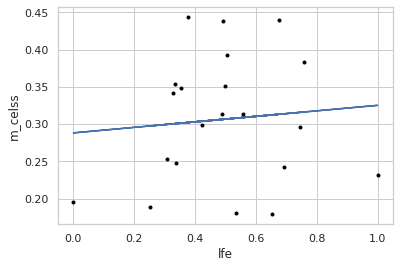

In [234]:
corr = pearsonr(df_lfe_mcells['lfe'], df_lfe_mcells['m_cells'])
print("Pearson Correlation score : ", corr)

plt.figure()
x = df_lfe_mcells['lfe']
y = df_lfe_mcells['m_cells']

# normalise ivector
x = (x-x.min())/(x.max()-x.min())

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

plt.plot(x,y , '.', color="black")
plt.xlabel('lfe')
plt.ylabel('m_celss')


To do : rerun LFE on the 25 languages to see if we manage to go somewhere ?